### Dynamic optimization

In [1]:
from pyomo.environ import *
import numpy as np
from pyomo.dae import *
import matplotlib.pyplot as plt

In [2]:
# Model
m = ConcreteModel()
m.time = ContinuousSet(bounds=(0,20))

max_ind = 2
m.S = RangeSet(1, max_ind)

# Parameters
dH = -3000
U = 300
E_R = 15075
k0 = 4.08e10
Cp = 0.75
Cpj = 1.0
rho = 50
rhoj = 62.3
Fo = 100 
Tjo = 530
Fj_ss = 30
tauI = 0.01

# Initial expressions
m.Cao = Expression(m.time, initialize=1)

def _step(m, t):
    if t <= 2.:
        return 600.
    elif 2 <= t < 7:
        return 600.*1.02
    elif 7 <= t < 10:
        return 600.*0.98
    elif 10 <= t < 15.2:
        return 600.*1.03
    else:
        return 600.*1.05

m.To = Expression(m.time, rule=_step)

# Steady-state variables
m.Ca_ss = Var(m.S, domain=NonNegativeReals, bounds=(0, 1), initialize=0.5)
m.T_ss = Var(m.S, domain=NonNegativeReals, bounds=(500, 700), initialize=600)
m.Tj_ss = Var(m.S, domain=NonNegativeReals, bounds=(500, 700), initialize=Tjo)


# Variables
m.Ca = Var(m.S, m.time, domain=NonNegativeReals, bounds=(0, 1))
m.T = Var(m.S, m.time, domain=NonNegativeReals, bounds=(500, 700))
m.Tj = Var(m.S, m.time, domain=NonNegativeReals, bounds=(500, 700))
m.Fj = Var(m.S, m.time, domain=NonNegativeReals, 
    bounds=(0., Fj_ss*3), initialize=Fj_ss) # Manipulated variable

m.dCa = DerivativeVar(m.Ca)
m.dT = DerivativeVar(m.T)
m.dTj = DerivativeVar(m.Tj)

m.D =  Var(m.S, domain=NonNegativeReals, bounds=(5.5, 7.75))
m.H =  Var(m.S, domain=NonNegativeReals, bounds=(5.5, 7.75))

# Control
m.Kc = Var(m.S, domain=Reals, bounds=(-5, -0.01), initialize=-3)
m.I = Var(m.S, m.time)
m.dI = DerivativeVar(m.I)


def _k(m, s, i):
    return k0*exp(-E_R/m.T[s, i])
m.k = Expression(m.S, m.time, rule=_k)

def _V(m,s):
    return np.pi/4 * m.D[s]**2 * m.H[s]
m.V = Expression(m.S, rule=_V)

def _A(m,s):
    return np.pi*m.D[s]*m.H[s]
m.A = Expression(m.S, rule=_A)

def _Vj(m,s):
    return m.A[s]/3
m.Vj = Expression(m.S, rule=_Vj)

# ------------------------------------------------------------------------------------------------
# Steady-state calculation

def _k_ss(m, s):
    return k0*exp(-E_R/m.T_ss[s])
m.k_ss = Expression(m.S, rule=_k_ss)


def _ode1_ss(m,s):
    if s == 1:
        return 0 == (Fo*(m.Cao[0] - m.Ca_ss[s]) - m.V[s]*m.k_ss[s]*m.Ca_ss[s])/m.V[s]
    else:
        return 0 == (Fo*(m.Ca_ss[s-1] - m.Ca_ss[s]) - m.V[s]*m.k_ss[s]*m.Ca_ss[s])/m.V[s]
m.ode1_ss = Constraint(m.S, rule=_ode1_ss)


def _ode2_ss(m,s):
    if s == 1:
        return 0 == (Cp*rho*Fo*(m.To[0] - m.T_ss[s]) - dH*m.V[s]*m.k_ss[s]*m.Ca_ss[s] \
            - U*m.A[s]*(m.T_ss[s] - m.Tj_ss[s]))/(m.V[s]*Cp*rho)
    
    else:
        return 0 == (Cp*rho*Fo*(m.T_ss[s-1] - m.T_ss[s]) - dH*m.V[s]*m.k_ss[s]*m.Ca_ss[s] \
            - U*m.A[s]*(m.T_ss[s] - m.Tj_ss[s]))/(m.V[s]*Cp*rho)
        
m.ode2_ss = Constraint(m.S, rule=_ode2_ss)


def _ode3_ss(m,s):
    return 0 == (Cpj*rhoj*Fj_ss*(Tjo - m.Tj_ss[s]) + U*m.A[s]*\
        (m.T_ss[s] - m.Tj_ss[s]))/(m.Vj[s]*Cpj*rhoj)

m.ode3_ss = Constraint(m.S, rule=_ode3_ss)

# ---------------------------------------------------------------------------------------------------------------

def _error(m, s, t):
    return (m.T[s, t] - m.T_ss[s])
m.err = Expression(m.S, m.time, rule=_error)


# Constraints -- ODEs
def _Ival(m,s,i):
    if i == 0 :
        return Constraint.Skip
    return m.dI[s,i] == m.err[s,i]
m.ode_I = Constraint(m.S, m.time, rule=_Ival)

def _cons1(m,s,i):
    return m.Fj[s,i] == Fj_ss + m.Kc[s]*(m.err[s,i] + m.I[s,i]/tauI)
m.cons1 = Constraint(m.S, m.time, rule=_cons1)

def _ode1(m,s,i):
    if s == 1:
        if i == 0 :
            return Constraint.Skip
        return m.dCa[s,i] == (Fo*(m.Cao[i] - m.Ca[s,i]) - m.V[s]*m.k[s,i]*m.Ca[s,i])/m.V[s]
    
    else:
        if i == 0 :
            return Constraint.Skip
        return m.dCa[s,i] == (Fo*(m.Ca[s-1, i] - m.Ca[s,i]) - m.V[s]*m.k[s,i]*m.Ca[s,i])/m.V[s]

m.ode1 = Constraint(m.S, m.time, rule=_ode1)


def _ode2(m,s,i):
    if s == 1:
        if i == 0 :
            return Constraint.Skip
        return m.dT[s,i] == (Cp*rho*Fo*(m.To[i] - m.T[s,i]) - dH*m.V[s]*m.k[s,i]*m.Ca[s,i]\
        - U*m.A[s]*(m.T[s,i] - m.Tj[s,i]))/(m.V[s]*Cp*rho)
    
    else:
        if i == 0 :
            return Constraint.Skip
        return m.dT[s,i] == (Cp*rho*Fo*(m.T[s-1,i] - m.T[s,i]) - dH*m.V[s]*m.k[s,i]*m.Ca[s,i]\
        - U*m.A[s]*(m.T[s,i] - m.Tj[s,i]))/(m.V[s]*Cp*rho)

m.ode2 = Constraint(m.S, m.time, rule=_ode2)


def _ode3(m,s,i):
    if i == 0 :
        return Constraint.Skip
    return m.dTj[s,i] == (Cpj*rhoj*m.Fj[s,i]*(Tjo - m.Tj[s,i]) + U*m.A[s]*\
        (m.T[s,i] - m.Tj[s,i]))/(m.Vj[s]*Cpj*rhoj)

m.ode3 = Constraint(m.S,m.time, rule=_ode3)

def final_cons(m):
    return m.Ca[max_ind,20] <= 1-0.85

m.final_cons = Constraint(rule=final_cons)



def _intX(m,s,i):
    return (m.err[s,i]**2)
m.intX = Integral(m.S,m.time, wrt=m.time, rule=_intX)

    

def objetive(m):
    cost_min = 1916.9*5.5**(1.066)*5.5**(0.802)
    cost_max = 1916.9*7.75**(1.066)*7.75**(0.802)
    cap_cost = sum((1916.9*m.D[s]**(1.066)*m.H[s]**(0.802) - cost_min)/(cost_max-cost_min) for s in m.S)
    mu = sum(m.intX[s] for s in m.S)

    return cap_cost + mu
m.obj = Objective(rule=objetive, sense=minimize)


def _init(m):
    for s in m.S:
        yield m.Ca[s,0] == m.Ca_ss[s] 
        yield m.T[s,0] == m.T_ss[s]
        yield m.T[s,20] == m.T_ss[s]
        yield m.Tj[s,0] == m.Tj_ss[s]
        yield m.I[s,0] == 0. 
m.initcon = ConstraintList(rule=_init)

In [3]:
# Discretization and solver
discretizer = TransformationFactory('dae.collocation')
discretizer.apply_to(m,nfe=80,scheme='LAGRANGE-RADAU',ncp=3)
solver = SolverFactory('ipopt')

solver.solve(m)

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 4339, 'Number of variables': 4342, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.6.1\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 52.9265501499176}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

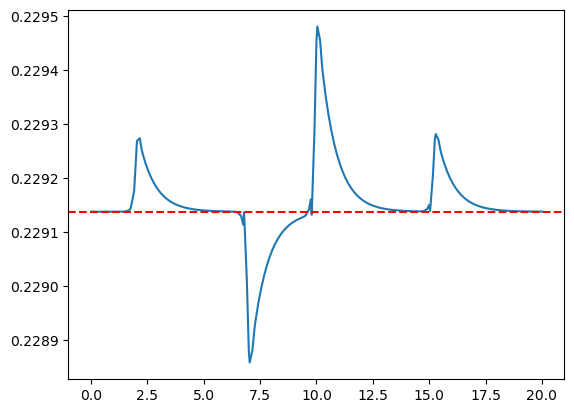

In [4]:
x = []
v = []
u = []
y = []
time=[]
for i in m.time:
    time.append(i)
    x.append(value(m.Ca[1,i]))

plt.plot(time,x,label='Ca')
plt.axhline(y=value(m.Ca_ss[1]), color = 'red', linestyle = '--', label='SP')